# Local Simulators for Q-Trainer

With PennyLane as interface of Q-Trainer, various local simulators are available for training variational circuits. 

Here we show a list of local simulators.

| **Simulator** | **Platform** | **Package** | **CPU/GPU** | **Pure/Mixed State** |
|---|---|---|---|---|
| `default.qubit` | PennyLane | `pennylane` | CPU | Pure |
| `default.mixed` | PennyLane | `pennylane` | CPU | Mixed |
| `lightning.qubit` | PennyLane | `pennylane-lightning` | CPU | Pure |
| `lightning.gpu` | PennyLane | `pennylane-lightning` | GPU | Pure |
| `braket.local.qubit` | Braket | `amazon-braket-pennylane-plugin` | CPU | Pure/Mixed |
| `cirq.simulator` | Cirq | `pennylane-cirq` | CPU | Pure |
| `cirq.qsim` | Cirq | `pennylane-cirq` | CPU | Pure |
| `qiskit.basicaer` | Qiskit | `pennylane-qiskit` | CPU | Pure |
| `qiskit.aer` | Qiskit | `pennylane-qiskit` | CPU | Pure |

In this tutorial, we use a QAOA problem as an example to show the use of different simulators.

In [1]:
import qtrainer
import networkx as nx
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

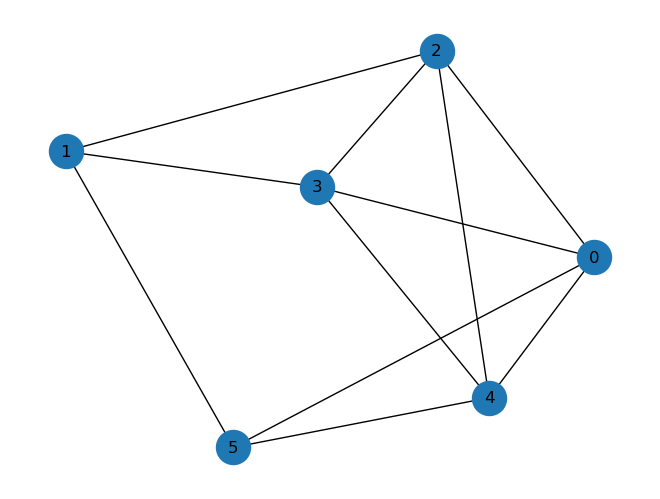

In [2]:
n_nodes = 6
p = 0.5  # probability of an edge
seed = 1967
g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)
nx.draw(g, with_labels=True, pos=positions, node_size=600)
task = "maxcut"
depth = 2
circuit = qtrainer.circuits.QAOACircuit(graph=g, task=task, depth=depth, seed=0)

In [3]:
noise_gate = qml.DepolarizingChannel
noise_strength = 0.1
noise_fn = qml.transforms.insert(noise_gate, noise_strength, position="all")

## Trainer
+ `circuit`: Q-Trainer Circuit class
+ `device_name`: Pennylane-stype device name. (For noised simulation, use `default.mixed`/`cirq.mixedsimulator`/`braket_dm`.)
+ `optimizer`: could be `Adam`, `SGD`, `ShotAdaptive`, `SPSA`, etc.
+ `noise_fn`: preset noise function
+ `error_mitigation_method`: Quantum error mitigation method. Currently, only Zero-Noise Zxtrapolation (`zne`) is supported
+ `n_steps`: number of optimization steps

In [4]:
train_config = dict(
    optimizer = 'Adam',
    optimizer_config={'stepsize': 1},
    n_steps = 10,
    shots_per_step = 100,
    eval_freq = 5
)

## PennyLane Simulators

PennyLane has multiple native local simulators, with device names as `default.xxx` or `lightning.xxx`. The PennyLane Lightning simulators need to be installed separately via `pip install pennylane-lightning`.

+ `default.qubit` and `lightning.qubit`: state-vector CPU simulators.

In [5]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'default.qubit',**train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'lightning.qubit',**train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

+ `lightning.gpu`: state-vector GPU simulator - needs at least one NVIDIA GPU available on your machine.

In [7]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'lightning.gpu',**train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

+ `default.mixed`: mixed-state CPU simulator - can be used to simulate noisy channels

In [8]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'default.mixed',
                           noise_fn=noise_fn, **train_config,)
trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

## Braket Simulators

+ `braket.local.qubit`: local CPU simulators - can be used with two types of backend
    + `backend="braket_sv"`: State-vector simulator
    + `backend="braket_dm"`: Mixed-state simulator

In [9]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'braket.local.qubit', device_config = {'backend':"braket_sv"},
                           **train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'braket.local.qubit', device_config = {'backend':"braket_dm"},
                           noise_fn=noise_fn,**train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

## Cirq Simulators

+ `cirq.simulator`: state-vector CPU simulator
+ `cirq.qsim`: state-vector CPU simulator - faster than `cirq.simulator`
    + Need to install the `qsimcirq` package first (`pip install qsimcirq`).

In [11]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'cirq.simulator',
                           **train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'cirq.qsim',**train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

## Qiskit Simulators
+ `qiskit.basicaer`: state-vector CPU simulator
+ `qiskit.aer`: state-vector CPU simulator - faster than `qiskit.basicaer`
    + In principle, `qiskit.aer` should be able to do mixed-state (noisy) simulation. However, the current `pennylane-qiskit` plugin package does not fully support noisy simulations. So, here we introduce it as a state-vector simulator.

In [13]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'qiskit.basicaer',
                           **train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
circuit.initialize_params()
trainer = qtrainer.Trainer(circuit, device_name = 'qiskit.aer',
                           **train_config,)
_ = trainer.train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]